In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
# Load dataset
data = pd.read_csv('creditcard.csv')

# Check for null values
null_values = data.isnull().sum()
print("Null values in each column:\n", null_values)

# Basic statistics
basic_stats = data.describe()
print("\nBasic statistics:\n", basic_stats)

# Data types
data_types = data.dtypes
print("\nData types:\n", data_types)

# Check for duplicates
duplicates = data.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)

# Handle missing values (drop rows with null values for this example)
data_cleaned = data.dropna()

# Standardise 'Time' and 'Amount'
scaler = StandardScaler()
data_cleaned[['Time', 'Amount']] = scaler.fit_transform(data_cleaned[['Time', 'Amount']])

# Resample the data using SMOTE
X = data_cleaned.drop('Class', axis=1)
y = data_cleaned['Class']
smote = SMOTE()
# X_res, y_res = smote.fit_resample(X, y) 
#I chose to not use SMOTE as it was ineffective
X_res, y_res = X, y

# Quick check on the shape of the new dataset
print("\nResampled data shape:", X_res.shape)

# Now you're all set to proceed with your feature selection and model training!


Null values in each column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Basic statistics:
                 Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%   

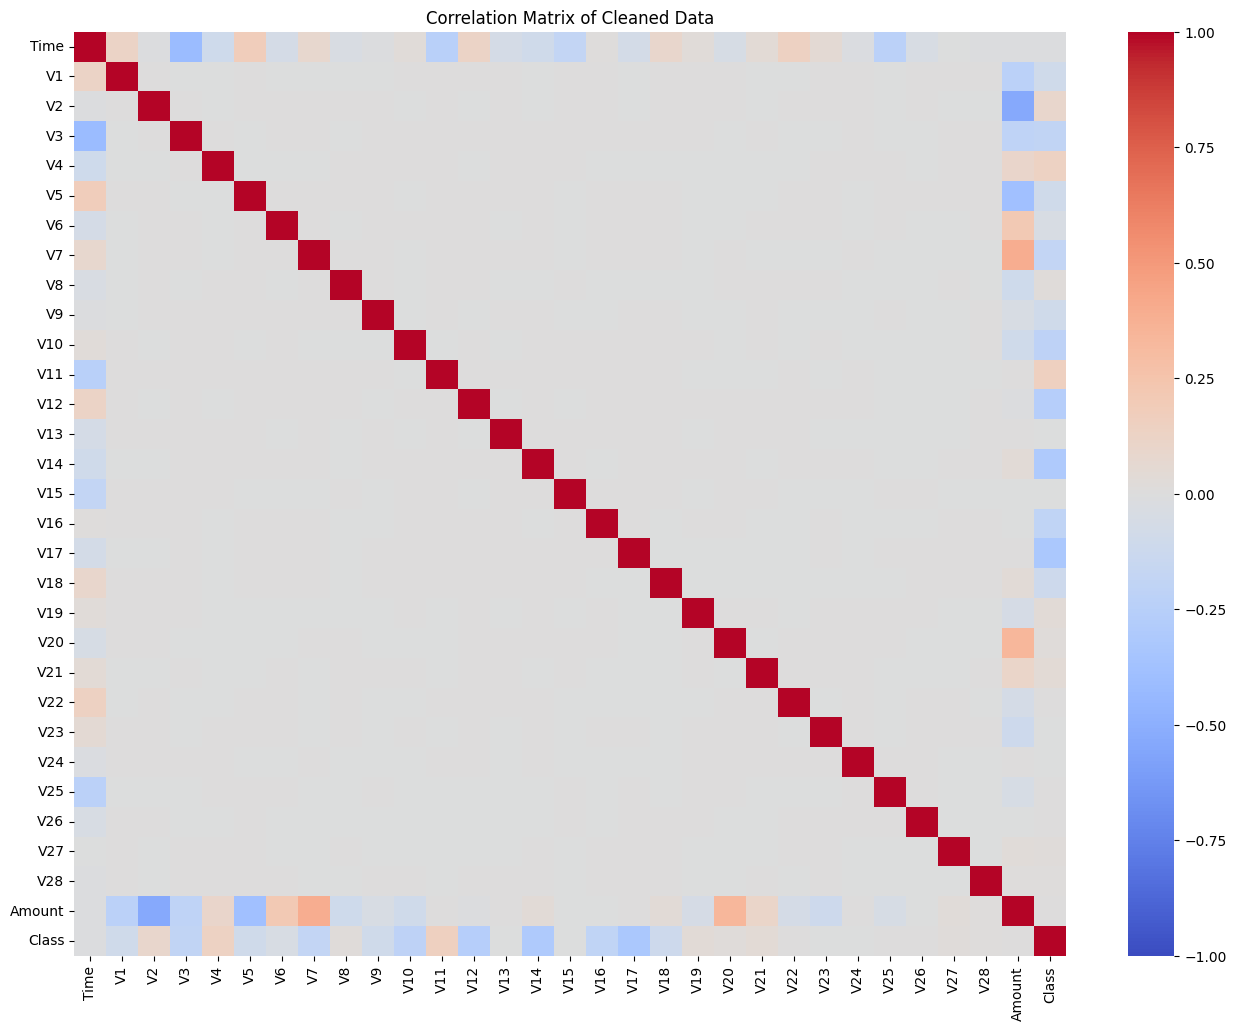

In [46]:
# Compute the correlation matrix
corr_matrix = data_cleaned.corr()

# Plot the correlation matrix without annotations
plt.figure(figsize=(16, 12))  # Increase the figure size
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Cleaned Data')
plt.show()


In [6]:
def create_tf_model():
    model = Sequential()
    model.add(Input(shape=(X_res.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='AUC')])
    return model

# Define model parameters
params = {
    'Logistic Regression': {'C': 1.0, 'max_iter': 100},
    'Random Forest': {'n_estimators': 80, 'max_depth': 4},
    'Isolation Forest': {'contamination': 0.172/100},
    'Neural Network (TensorFlow)': {'epochs': 100, 'batch_size': 16, 'validation_split': 0.2}
}

# Create models with parameters
models = {
    'Logistic Regression': LogisticRegression(**params['Logistic Regression']),
    'Random Forest': RandomForestClassifier(**params['Random Forest']),
    'Isolation Forest': IsolationForest(**params['Isolation Forest']),
    'Neural Network (TensorFlow)': create_tf_model()
}


In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_AUC', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_AUC', factor=0.1, patience=2, min_lr=0.0001)

# Train TensorFlow model
tf_model = models['Neural Network (TensorFlow)']
tf_model.fit(X_res, y_res, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Predict and evaluate
y_pred_tf = (tf_model.predict(X_res) > 0.5).astype("int32")
y_proba_tf = tf_model.predict(X_res)

# Collect evaluation metrics
results_tf = {
    'Model': 'Neural Network (TensorFlow)',
    'Accuracy': accuracy_score(y_res, y_pred_tf),
    'Precision': precision_score(y_res, y_pred_tf),
    'Recall': recall_score(y_res, y_pred_tf),
    'F1 Score': f1_score(y_res, y_pred_tf),
    'AUPRC': average_precision_score(y_res, y_proba_tf)
}


Epoch 1/100
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - AUC: 0.8635 - loss: 0.0107 - val_AUC: 0.9197 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/100
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step - AUC: 0.9418 - loss: 0.0031 - val_AUC: 0.9131 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/100
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - AUC: 0.9431 - loss: 0.0035 - val_AUC: 0.8865 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 4/100
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - AUC: 0.9451 - loss: 0.0034 - val_AUC: 0.8999 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 5/100
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - AUC: 0.9512 - loss: 0.0031 - val_AUC: 0.9261 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 6/100
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - AUC: 0.9608 - loss: 0.0023 - val_AUC: 0.9132 - val_loss: 0.0031 - learning_rate: 1.0000e-04
Epoch 7/100
14241/14241 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - AUC: 0.9576 - loss: 0.0027 - val_AUC: 0.8999 - v

In [9]:
# Define AUPRC scorer
auprc_scorer = make_scorer(average_precision_score, response_method='predict_proba')

results = []
for name, model in models.items():
    print(name)
    if name == 'Neural Network (TensorFlow)':
        # TensorFlow model is handled separately
        continue
    
    #sfs = SFS(model, k_features='best', forward=True, floating=True, scoring=auprc_scorer, cv=5)
    #sfs = sfs.fit(X_res, y_res)
    #X_selected = sfs.transform(X_res)
    X_selected = X_res
    model.fit(X_selected, y_res)
    y_pred = model.predict(X_selected)
    y_proba = model.predict_proba(X_selected)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_res, y_pred),
        'Precision': precision_score(y_res, y_pred, average='weighted'),
        'Recall': recall_score(y_res, y_pred, average='weighted'),
        'F1 Score': f1_score(y_res, y_pred, average='weighted'),
        'AUPRC': average_precision_score(y_res, y_proba)
    })

# Append TensorFlow results
results.append(results_tf)

# Output results
results_df = pd.DataFrame(results)
print(results_df)


Logistic Regression
Random Forest
Isolation Forest
Neural Network (TensorFlow)
                         Model  Accuracy  Precision    Recall  F1 Score  \
0          Logistic Regression  0.999217   0.999160  0.999217  0.999152   
1                Random Forest  0.999403   0.999377  0.999403  0.999359   
2             Isolation Forest  0.001275   0.000002  0.001275  0.000004   
3  Neural Network (TensorFlow)  0.999589   0.931034  0.823171  0.873786   

      AUPRC  
0  0.767518  
1  0.826877  
2  0.001395  
3  0.900816  


C:\Users\Arjun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Arjun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
# Combine Predictions for Ensemble
y_proba_logreg = models['Logistic Regression'].predict_proba(X_res)[:, 1]
y_proba_rf = models['Random Forest'].predict_proba(X_res)[:, 1]
y_proba_ensemble = (y_proba_logreg + y_proba_rf + y_proba_tf.squeeze()) / 3
y_pred_ensemble = (y_proba_ensemble > 0.5).astype(int)

# Collect evaluation metrics for Ensemble
results_ensemble = {
    'Model': 'Ensemble',
    'Accuracy': accuracy_score(y_res, y_pred_ensemble),
    'Precision': precision_score(y_res, y_pred_ensemble, average='weighted'),
    'Recall': recall_score(y_res, y_pred_ensemble, average='weighted'),
    'F1 Score': f1_score(y_res, y_pred_ensemble, average='weighted'),
    'AUPRC': average_precision_score(y_res, y_proba_ensemble)
}

# Append Ensemble results
results.append(results_ensemble)

# Output all results
results_df = pd.DataFrame(results)
print(results_df)


                         Model  Accuracy  Precision    Recall  F1 Score  \
0          Logistic Regression  0.999217   0.999160  0.999217  0.999152   
1                Random Forest  0.999403   0.999377  0.999403  0.999359   
2             Isolation Forest  0.001275   0.000002  0.001275  0.000004   
3  Neural Network (TensorFlow)  0.999589   0.931034  0.823171  0.873786   
4                     Ensemble  0.999435   0.999407  0.999435  0.999408   

      AUPRC  
0  0.767518  
1  0.826877  
2  0.001395  
3  0.900816  
4  0.876067  


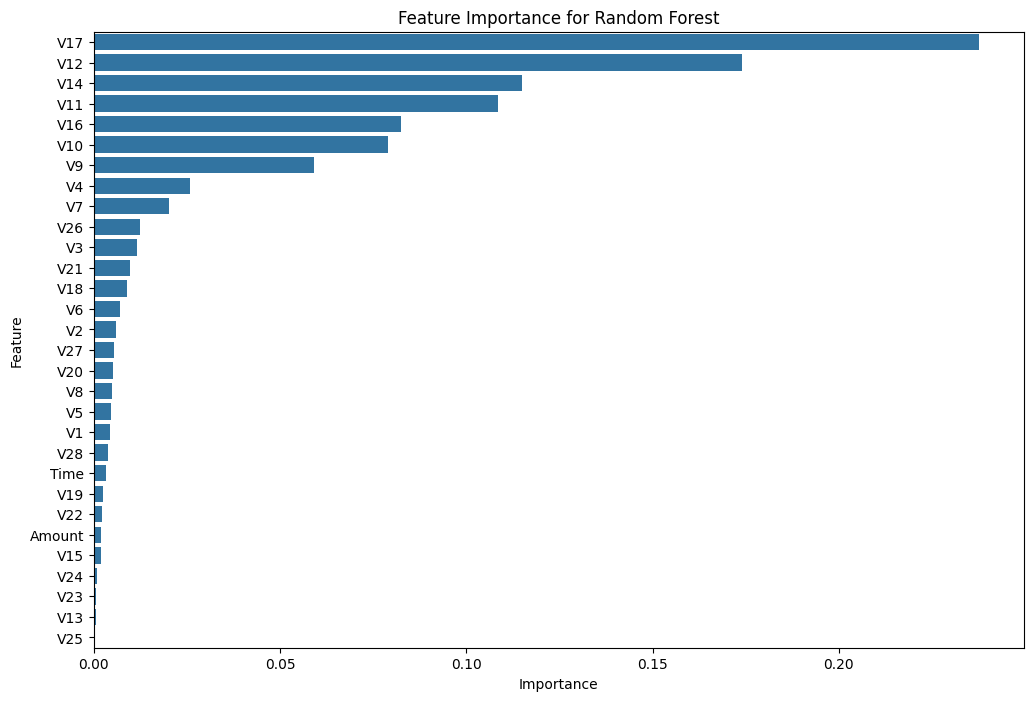

In [29]:
# Fit the Random Forest model
rf = models['Random Forest']
rf.fit(X_res, y_res)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


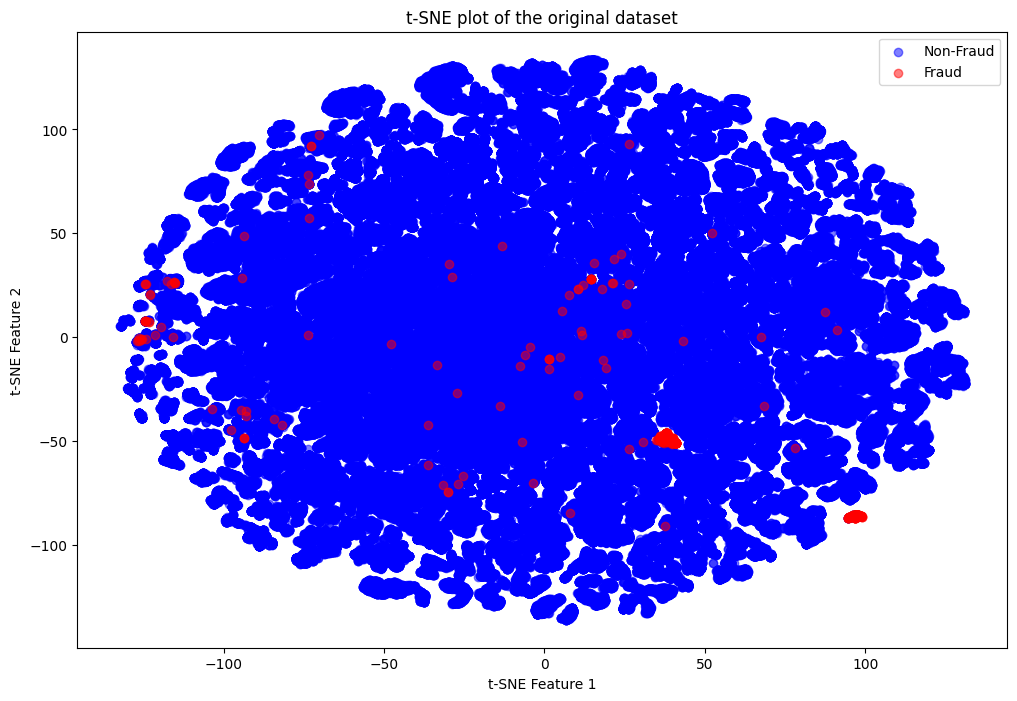

In [30]:
# Prepare data for t-SNE (excluding target column 'Class')
X_original = data_cleaned.drop('Class', axis=1)
y_original = data_cleaned['Class']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[y_original == 0, 0], X_tsne[y_original == 0, 1], c='blue', label='Non-Fraud', alpha=0.5)
plt.scatter(X_tsne[y_original == 1, 0], X_tsne[y_original == 1, 1], c='red', label='Fraud', alpha=0.5)
plt.legend()
plt.title('t-SNE plot of the original dataset')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


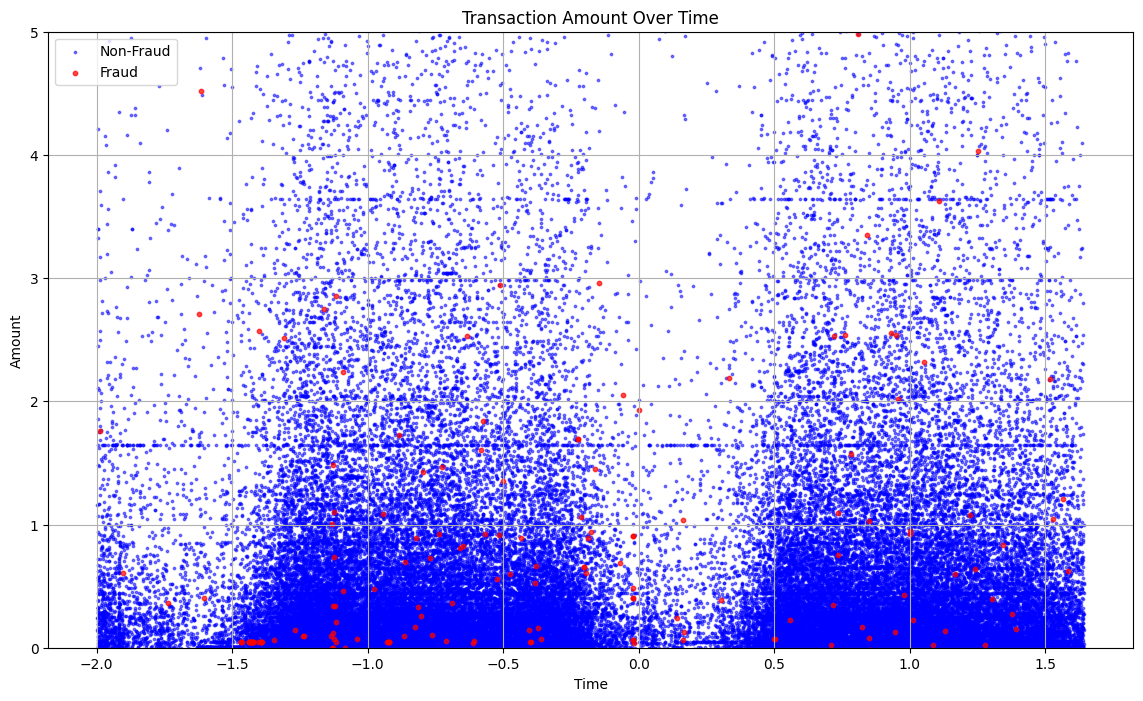

In [41]:
# Plot Amount over Time
plt.figure(figsize=(14, 8))

# Non-Fraudulent transactions
plt.scatter(data_cleaned[data_cleaned['Class'] == 0]['Time'], 
            data_cleaned[data_cleaned['Class'] == 0]['Amount'], 
            c='blue', label='Non-Fraud', alpha=0.5, s=3)

# Fraudulent transactions
plt.scatter(data_cleaned[data_cleaned['Class'] == 1]['Time'], 
            data_cleaned[data_cleaned['Class'] == 1]['Amount'], 
            c='red', label='Fraud', alpha=0.7, s=10)

plt.ylim(0, 5)  # Zoom in on the y-axis
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Transaction Amount Over Time')
plt.legend()
plt.grid(True)
plt.show()

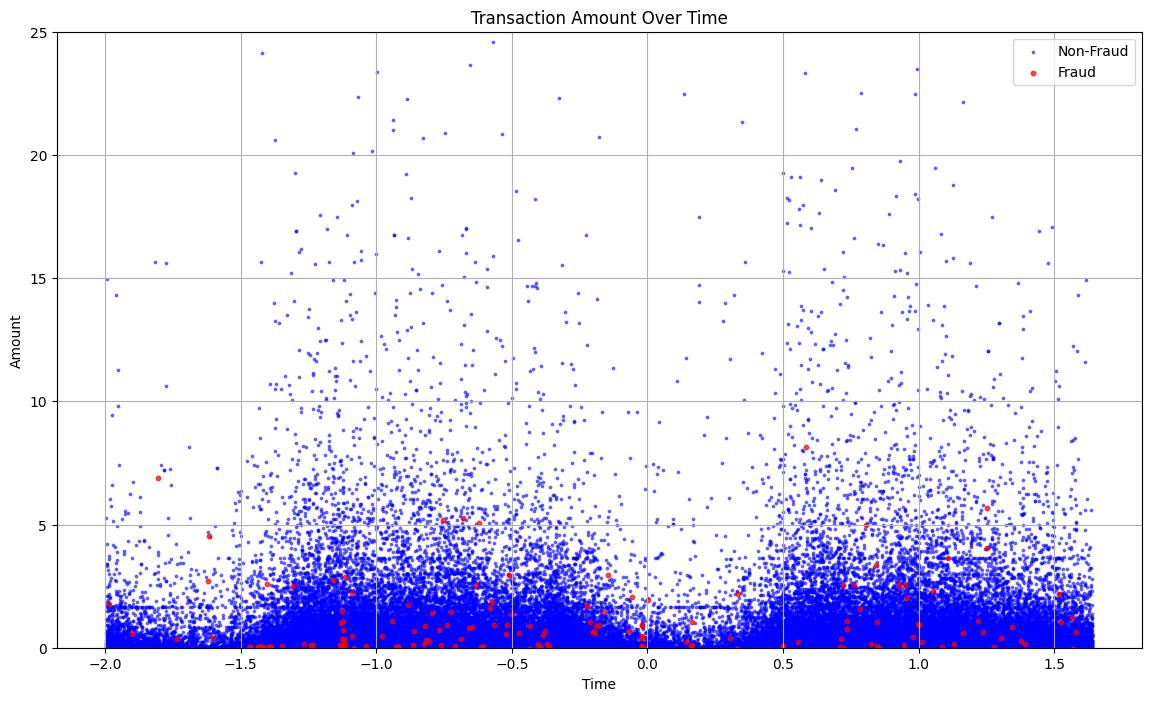

In [43]:
# Plot Amount over Time
plt.figure(figsize=(14, 8))

# Non-Fraudulent transactions
plt.scatter(data_cleaned[data_cleaned['Class'] == 0]['Time'], 
            data_cleaned[data_cleaned['Class'] == 0]['Amount'], 
            c='blue', label='Non-Fraud', alpha=0.5, s=3)

# Fraudulent transactions
plt.scatter(data_cleaned[data_cleaned['Class'] == 1]['Time'], 
            data_cleaned[data_cleaned['Class'] == 1]['Amount'], 
            c='red', label='Fraud', alpha=0.7, s=10)

plt.ylim(0, 25)  # Zoom in on the y-axis
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Transaction Amount Over Time')
plt.legend()
plt.grid(True)
plt.show()

